# Preprocessing STEP 1

Starting from a raw iEEG-BIDS object, these steps should be performed in order:

1. Load data
2. Visualize PSD
3. Inspect and remove bad channels 
4. Manually annotate ictal events in raw file (but do not reject)
5. Rereference
6. Epoch data from events array, rejecting epochs that contain artifact
7. Export as epochs iEEG-BIDS

https://mne.tools/stable/generated/mne.set_bipolar_reference.html#mne.set_bipolar_reference

https://mne.tools/stable/auto_tutorials/clinical/30_ecog.html

https://mne.tools/dev/auto_tutorials/clinical/20_seeg.html

https://www.sv.uio.no/psi/english/research/projects/human-time-data/documents/data-lifecycle/ieeg/resources/ieeg-doc-firstdraft.pdf

https://www.fieldtriptoolbox.org/tutorial/human_ecog/

https://www.fieldtriptoolbox.org/example/rereference/

In [7]:
# imports
import os
import numpy as np
import scipy.io as sio
import scipy as sp
import pandas as pd
import mne
import mne_bids

from neurodsp import spectral
from neurodsp import filt

import matplotlib.pyplot as plt
# allows for interactive window
%matplotlib qt 

## 1. Load data

In [3]:
path = '/Users/sydneysmith/Projects/PrOPHEcy/iEEG_BIDS'

In [4]:
# first define the bids path
bids_path = mne_bids.BIDSPath(root=path, subject='1002', task='PrOPHEcy', datatype='ieeg', extension='edf') # task = 'PrOPHEcy'?

raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

# Pick only the ECoG channels, removing the EKG channels
raw.pick_types(seeg=True, stim=True)

# Load the data
raw.load_data()

Reading 0 ... 1234047  =      0.000 ...  2410.248 secs...


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_7339/2165780011.py:4: RuntimeWarning: The unit for channel(s) DC1, TRIG has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)


<RawEDF | sub-1002_task-PrOPHEcy_ieeg.edf, 144 x 1234048 (2410.2 s), ~1.32 GB, data loaded>

## 2. Visualize data 

As a first pass, plot a PSD to get an understanding for the nature of the data you're working with. This is useful because often, in clinical environments, there are unexpected sources of noise beyond the usual 60 Hz line noise. Plotting a PSD helps you identify any odd data properties before any changes are made to the data.

Effective window size : 4.000 (s)


/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_7339/3341777298.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd();


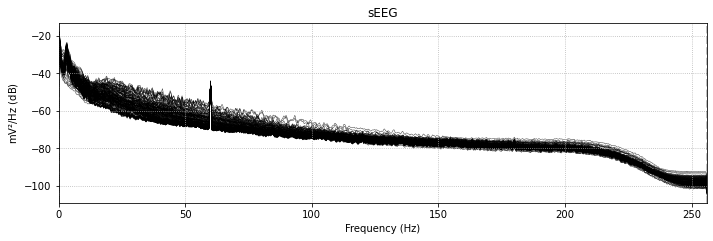

In [5]:
raw.plot_psd();

## 3. Plot raw data and mark bad channels

By visual inspection, identify and remove bad channels that have poor contact quality. Mark a channel as bad by clicking on its corresponding label on the Y-axis. Channels marked as bad will appear gray, are logged in the MNE Info object, and automatically rejected. Do this step before rereferencing to ensure that no bad channels inject artifactual noise into other channels.

A bad channel likely has high-amplitude, consistent 60Hz line noise, indicating poor connection quality. Keep the position of the electrode in relation to each shank. Also, just because an electrode looks different from those next to it does not necessarily indicate a bad contact--it could be an electrode in CSF or white matter vs. grey matter.

Adjust plot scalings to best suit data. A good starting place for iEEG is the MNE default. You might need to plot and replot several times to get the best scalings.

Using matplotlib as 2D backend.


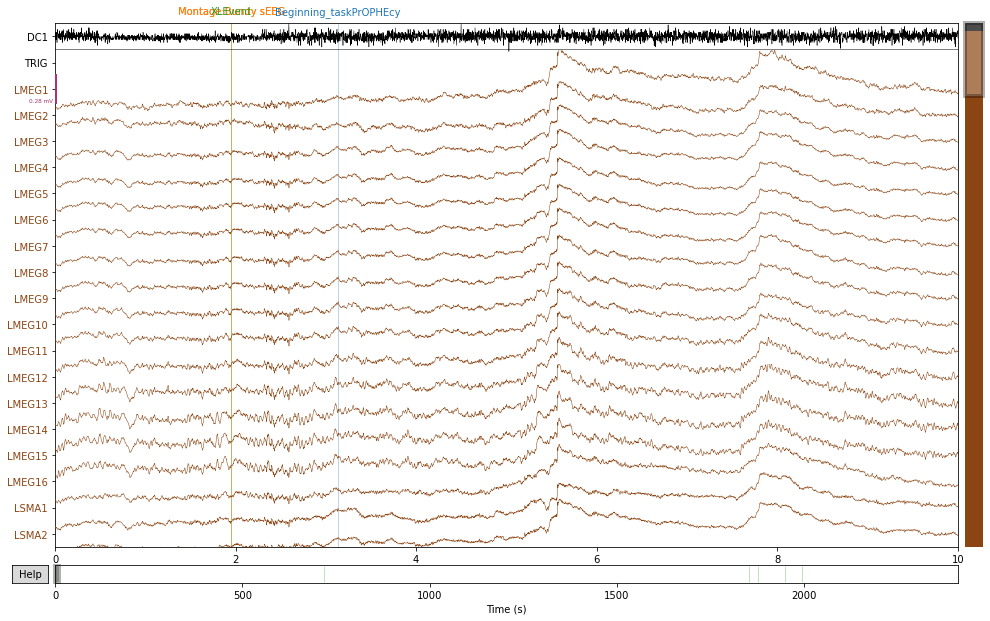

In [6]:
scalings = {'seeg' : 140e-6}
raw.plot(scalings=scalings);

## 4. Manually annotate ictal activity

Perform this step before rereferencing. This should not include minor motor artifacts, only large, clearly ictal events. These events will be useful when epoching the data, so epochs that contain ictal activity can be rejected from the overall file. 

It is important to annotate these events prior to rereferencing because rereferencing can possibly remove the visible presence of these events (due to their diffuse spatial properties). However, this data should not be included in the final epochs object because this activity is pathological and therefore, behavior during ictal periods is inherently ungeneralizable. 

Instructions for how to annotate:  

1. Plot raw data   
2. Locate ictal artifact (*NOTE provided examples*)  
3. Press 'A' to open annotation window  
4. Create new annotation label, must contain 'BAD' for automated rejection later (eg. 'BAD_ictal')  
5. Click and drag mouse, highlighting window of time containing ictal event. (be conservative and precise with highlighting, at risk of later on rejecting epochs that might not contain ictal activity)  
6. When finished, close annotation window and raw.plot window. No save required.  

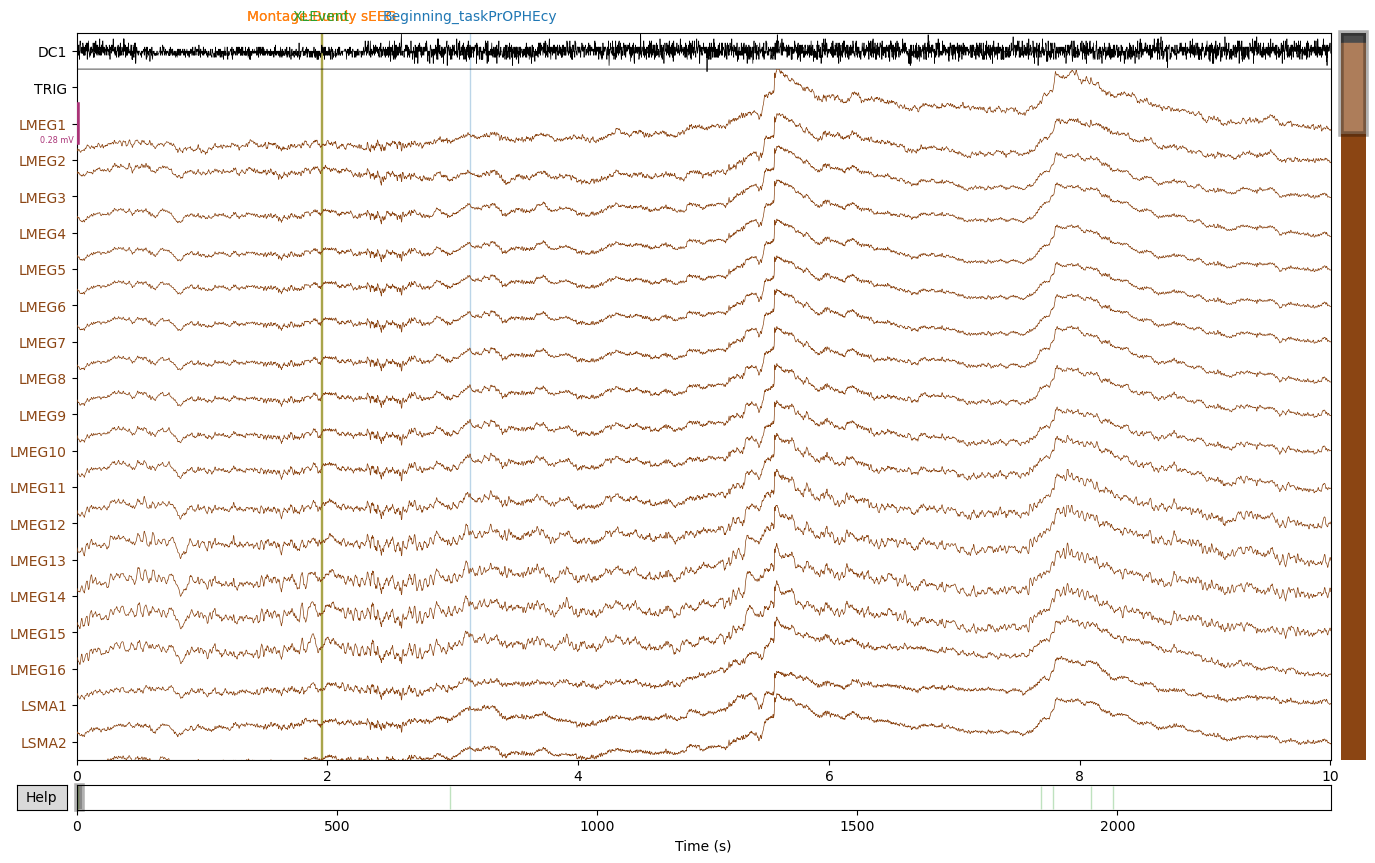

Channels marked as bad: none


In [8]:
raw_annotate = raw.copy()
raw_annotate.plot(scalings=scalings)

# 5. Rereferencing

Types of rereferencing schemes
1. average 
    a. by shank (specific to sEEG)
    b. by grid (for ECoG)
2. bipolar
3. spatial
    a. a-prori oscillations (eg. alpha, mu)
4. White-matter (non-neural electrode)

## 5.1 Average by shank

Segment all the electrodes on each shank using the following interactive cells
1. print all channel names
2. copy & paste all the channel names for each shank into the input box
3. when finished, type 'done'

channel names are stored as a list of lists as shank_list

In [17]:
# manual electrode assignment to shank

ch_names = raw.info['ch_names']
print(ch_names)

['LMEG1', 'LMEG2', 'LMEG3', 'LMEG4', 'LMEG5', 'LMEG6', 'LMEG7', 'LMEG8', 'LMEG9', 'LMEG10', 'LMEG11', 'LMEG12', 'LMEG13', 'LMEG14', 'LMEG15', 'LMEG16', 'LSMA1', 'LSMA2', 'LSMA3', 'LSMA4', 'LSMA5', 'LSMA6', 'LSMA7', 'LSMA8', 'LSMA9', 'LSMA10', 'LSMA11', 'LSMA12', 'LSMA13', 'LSMA14', 'LPPV1', 'LPPV2', 'LPPV3', 'LPPV4', 'LPPV5', 'LPPV6', 'LPPV7', 'LPPV8', 'LPPV9', 'LPPV10', 'LPPV11', 'LPPV12', 'LPPV13', 'LPPV14', 'LPPV15', 'LPPV16', 'LTH1', 'LTH2', 'LTH3', 'LTH4', 'LTH5', 'LTH6', 'LTH7', 'LTH8', 'LTH9', 'LTH10', 'LTH11', 'LTH12', 'LTH13', 'LTH14', 'LTH15', 'LTH16', 'LMEGOF1', 'LMEGOF2', 'LMEGOF3', 'LMEGOF4', 'LMEGOF5', 'LMEGOF6', 'LMEGOF7', 'LMEGOF8', 'LMEGOF9', 'LMEGOF10', 'LMEGOF11', 'LMEGOF12', 'LMEGOF13', 'LMEGOF14', 'LMEGOF15', 'LMEGOF16', 'RTH1', 'RTH2', 'RTH3', 'RTH4', 'RTH5', 'RTH6', 'RTH7', 'RTH8', 'RTH9', 'RTH10', 'RTH11', 'RTH12', 'RTH13', 'RTH14', 'RTH15', 'RTH16', 'RSMA1', 'RSMA2', 'RSMA3', 'RSMA4', 'RSMA5', 'RSMA6', 'RSMA7', 'RSMA8', 'RSMA9', 'RSMA10', 'RSMA11', 'RSMA12', 'R

In [ ]:
def group_channels(raw):
    
    ### THIS FUNCTION IS ASS ### FIX LATER
    """Manually groups channels by shank and idenfity non-iEEG channels
    Returns:
    -------
    shank_list:
    trig_list:
    
    """
    shank_chans = ''
    shank_list = []
    trig_chans = ''
    trig_list = []
    proceed = 'n'
    proceed_trig = 'n'
    
    print('printing all channels...')
    
    ch_names = raw.info['ch_names']
    print(ch_names)
    print('\n\n')
    
    
    print('enter all channels on each shank as a list of strings (without brackets), excluding non-iEEG channels. When done, type done. \n')

#     print_info = 'printing all channels... \n' + str(ch_names) + '\n\n' + 'enter all channels on each shank as a list of strings (without brackets), excluding non-iEEG channels. When done, type "done". \n'
    
    while proceed=='n':
        while shank_chans != 'done':
            shank_chans = input('channels on shank: ');
            if shank_chans != 'done':
                shank_chans = list(eval(shank_chans))
                shank_list.append(shank_chans)
            else:
                break
        print('\n Here are your channels grouped by shank. Visually inspect them to make sure they were input correctly. \n')
        print(shank_list)
        proceed = input('Continue? (y/n)')
        assert proceed == 'y' or proceed == 'n'
    
    print('\n enter each trigger, or other non-iEEG channel one at a time as a string. When done, type done')

    while proceed_trig == 'n':
        while trig_chans != 'done':
            trig_chans = input('trigger/auxillary channel:');
            if trig_chans != 'done':

                try:
                    eval(trig_chans)
                except:
                    print('unable to interpret. please make sure channel name is a string')
                    break

                trig_chans = eval(trig_chans)

                assert isinstance(trig_chans,str), 'please enter each channel name separately'
                assert trig_chans in raw.info['ch_names'], 'channel not found in raw object'

                trig_list.append(trig_chans)

            else:
                break
        
# while trig_chans != 'done':
#     trig_chans = input('trigger/auxillary channels:');
#     if trig_chans != 'done':
#         trig_chans = eval(trig_chans)
#         trig_list.append(trig_chans)
#     else:
#         break

    
        print('\n Here are your non-iEEG channels. Any channels not included in these two lists will not be included in further preprocessing steps.\n')
        print(trig_list)
        proceed_trig = input('Continue? (y/n)')
        assert proceed_trig == 'y' or proceed_trig == 'n'
        
        
        if not os.path.isdir('./shank_info/'):
            os.mkdir('./shank_info/')
            np.save('./shank_info/shank_list.npy',np.asarray(shank_list, dtype=object))
            np.save('./shank_info/trig_list.npy',np.asarray(trig_list, dtype=object))
        
        else:
            overwrite = input('file already exists. Overwrite? (y/n)')
            if overwrite=='y':
                np.save('./shank_info/shank_list.npy',np.asarray(shank_list, dtype=object))
                np.save('./shank_info/trig_list.npy',np.asarray(trig_list, dtype=object))
                
            else:
                continue    

    return shank_list, trig_list


In [24]:
shank_list, trig_list = group_channels(raw=raw_annotate)

printing all channels...
['LMEG1', 'LMEG2', 'LMEG3', 'LMEG4', 'LMEG5', 'LMEG6', 'LMEG7', 'LMEG8', 'LMEG9', 'LMEG10', 'LMEG11', 'LMEG12', 'LMEG13', 'LMEG14', 'LMEG15', 'LMEG16', 'LSMA1', 'LSMA2', 'LSMA3', 'LSMA4', 'LSMA5', 'LSMA6', 'LSMA7', 'LSMA8', 'LSMA9', 'LSMA10', 'LSMA11', 'LSMA12', 'LSMA13', 'LSMA14', 'LPPV1', 'LPPV2', 'LPPV3', 'LPPV4', 'LPPV5', 'LPPV6', 'LPPV7', 'LPPV8', 'LPPV9', 'LPPV10', 'LPPV11', 'LPPV12', 'LPPV13', 'LPPV14', 'LPPV15', 'LPPV16', 'LTH1', 'LTH2', 'LTH3', 'LTH4', 'LTH5', 'LTH6', 'LTH7', 'LTH8', 'LTH9', 'LTH10', 'LTH11', 'LTH12', 'LTH13', 'LTH14', 'LTH15', 'LTH16', 'LMEGOF1', 'LMEGOF2', 'LMEGOF3', 'LMEGOF4', 'LMEGOF5', 'LMEGOF6', 'LMEGOF7', 'LMEGOF8', 'LMEGOF9', 'LMEGOF10', 'LMEGOF11', 'LMEGOF12', 'LMEGOF13', 'LMEGOF14', 'LMEGOF15', 'LMEGOF16', 'RTH1', 'RTH2', 'RTH3', 'RTH4', 'RTH5', 'RTH6', 'RTH7', 'RTH8', 'RTH9', 'RTH10', 'RTH11', 'RTH12', 'RTH13', 'RTH14', 'RTH15', 'RTH16', 'RSMA1', 'RSMA2', 'RSMA3', 'RSMA4', 'RSMA5', 'RSMA6', 'RSMA7', 'RSMA8', 'RSMA9', 'RSMA10

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [9]:
# TO DO: incorporate this info into function if it exists
imported_shanks = np.load('./shank_info/shank_list.npy', allow_pickle=True)
imported_trigs = np.load('./shank_info/trig_list.npy', allow_pickle=True)

In [10]:
imported_shanks

array([list(['LMEG1', 'LMEG2', 'LMEG3', 'LMEG4', 'LMEG5', 'LMEG6', 'LMEG7', 'LMEG8', 'LMEG9', 'LMEG10', 'LMEG11', 'LMEG12', 'LMEG13', 'LMEG14', 'LMEG15', 'LMEG16']),
       list(['LSMA1', 'LSMA2', 'LSMA3', 'LSMA4', 'LSMA5', 'LSMA6', 'LSMA7', 'LSMA8', 'LSMA9', 'LSMA10', 'LSMA11', 'LSMA12', 'LSMA13', 'LSMA14']),
       list(['LPPV1', 'LPPV2', 'LPPV3', 'LPPV4', 'LPPV5', 'LPPV6', 'LPPV7', 'LPPV8', 'LPPV9', 'LPPV10', 'LPPV11', 'LPPV12', 'LPPV13', 'LPPV14', 'LPPV15', 'LPPV16']),
       list(['LTH1', 'LTH2', 'LTH3', 'LTH4', 'LTH5', 'LTH6', 'LTH7', 'LTH8', 'LTH9', 'LTH10', 'LTH11', 'LTH12', 'LTH13', 'LTH14', 'LTH15', 'LTH16']),
       list(['LMEGOF1', 'LMEGOF2', 'LMEGOF3', 'LMEGOF4', 'LMEGOF5', 'LMEGOF6', 'LMEGOF7', 'LMEGOF8', 'LMEGOF9', 'LMEGOF10', 'LMEGOF11', 'LMEGOF12', 'LMEGOF13', 'LMEGOF14', 'LMEGOF15', 'LMEGOF16']),
       list(['RTH1', 'RTH2', 'RTH3', 'RTH4', 'RTH5', 'RTH6', 'RTH7', 'RTH8', 'RTH9', 'RTH10', 'RTH11', 'RTH12', 'RTH13', 'RTH14', 'RTH15', 'RTH16']),
       list(['RSMA1', 'R

In [11]:
def shank_avg_reference(raw, shank_list, trig_list):
    """rereferemce to common average of each shank of electrodes
   
    Parameters
    ----------
    raw: instance of MNE Raw Object
    shank_list:
    trig_list:
    
    Returns
    -------
    reref_raw: MNE Raw Object
        contains both non-iEEG channels and rereferenced shanks
    """
    
    reref_shanks = [] # list to be populated with MNE raw objects that represent each rereferenced shank
    
    # MNE object that contains trigger channels
    trig_obj = raw.copy().pick_channels(trig_list, ordered=True)
    
    # loop through list of shanks
    for shank in shank_list:
        print(shank[0])
        shank_obj = raw.copy().pick_channels(shank, ordered=True) # get selection of raw with shank channels
        shank_obj.set_eeg_reference('average') # rereference to average
        reref_shanks.append(shank_obj) # append to list of rereferenced shank objects
        
    # concatenate lists of rereferenced objects
    reref_raw = reref_shanks[0].add_channels(reref_shanks[1:])
    reref_raw = reref_raw.add_channels([trig_obj], force_update_info=True) # add non-iEEG channels
        
    return reref_raw

In [12]:
reref_raw = shank_avg_reference(raw=raw_annotate, shank_list=imported_shanks, trig_list=imported_trigs)

LMEG1
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
LSMA1
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
LPPV1
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
LTH1
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
LMEGOF1
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
RTH1
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
RSMA1
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
RMEG1
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
RFAC1
sEEG channel type selected for re-referenc

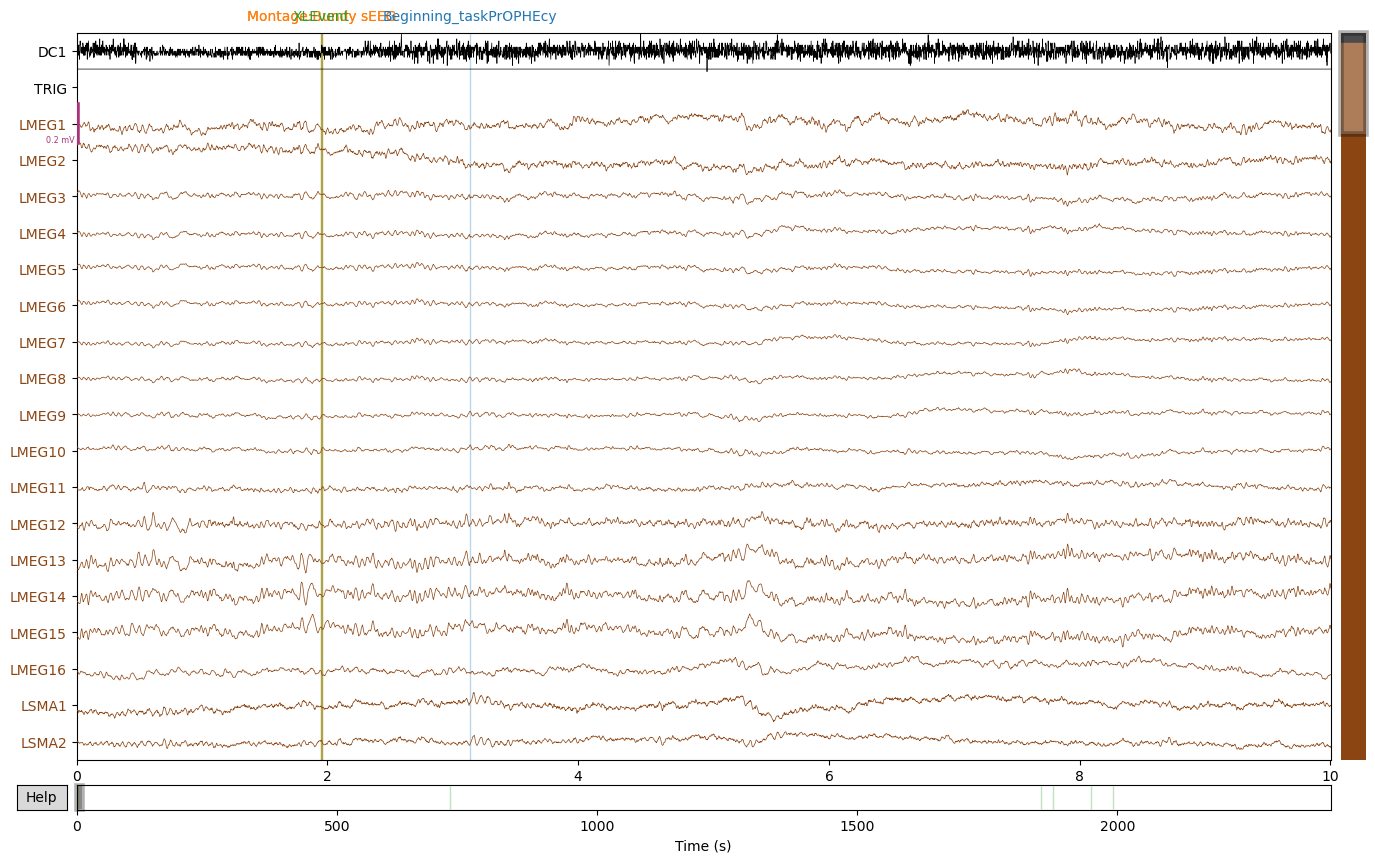

Channels marked as bad: none


In [13]:
reref_raw.plot()

## 5.2 Bipolar referencing

Set a bipolar reference scheme where each channel is referenced to the adjacent channel on each shank, creating n-1 virtual channels. This scheme captures much more focal activitiy compared to averaging-based references.

In [38]:
def bipolar_reference(raw, shank_list, trig_list):
    "get bipolar referenced object (each channel is referenced to adjacent channels on the shank)"
    
    # copy of raw for bipolar
    raw_bip_ref = raw.copy()
    for shank in shank_list:
        # get adjacent electode on shank
        raw_bip_ref = mne.set_bipolar_reference(raw_bip_ref, cathode=shank[0:-1], anode=shank[1:] )
        print(raw_bip_ref.info['ch_names'])
        
    return raw_bip_ref
        

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=15, n_times=1234048
    Range : 0 ... 1234047 =      0.000 ...  2410.248 secs
Ready.
Added the following bipolar channels:
LMEG2-LMEG1, LMEG3-LMEG2, LMEG4-LMEG3, LMEG5-LMEG4, LMEG6-LMEG5, LMEG7-LMEG6, LMEG8-LMEG7, LMEG9-LMEG8, LMEG10-LMEG9, LMEG11-LMEG10, LMEG12-LMEG11, LMEG13-LMEG12, LMEG14-LMEG13, LMEG15-LMEG14, LMEG16-LMEG15
['LSMA1', 'LSMA2', 'LSMA3', 'LSMA4', 'LSMA5', 'LSMA6', 'LSMA7', 'LSMA8', 'LSMA9', 'LSMA10', 'LSMA11', 'LSMA12', 'LSMA13', 'LSMA14', 'LPPV1', 'LPPV2', 'LPPV3', 'LPPV4', 'LPPV5', 'LPPV6', 'LPPV7', 'LPPV8', 'LPPV9', 'LPPV10', 'LPPV11', 'LPPV12', 'LPPV13', 'LPPV14', 'LPPV15', 'LPPV16', 'LTH1', 'LTH2', 'LTH3', 'LTH4', 'LTH5', 'LTH6', 'LTH7', 'LTH8', 'LTH9', 'LTH10', 'LTH11', 'LTH12', 'LTH13', 'LTH14', 'LTH15', 'LTH16', 'LMEGOF1', 'LMEGOF2', 'LMEGOF3', 'LMEGOF4', 'LMEGOF5', 'LMEGOF6', 'LMEGOF7', 'LMEGOF8', 'LMEGOF9', 'LMEGOF10', 'LMEGOF11', 'LMEGOF12', 'LMEGOF13', 'LMEGOF14',

['RTH1', 'RTH2', 'RTH3', 'RTH4', 'RTH5', 'RTH6', 'RTH7', 'RTH8', 'RTH9', 'RTH10', 'RTH11', 'RTH12', 'RTH13', 'RTH14', 'RTH15', 'RTH16', 'RSMA1', 'RSMA2', 'RSMA3', 'RSMA4', 'RSMA5', 'RSMA6', 'RSMA7', 'RSMA8', 'RSMA9', 'RSMA10', 'RSMA11', 'RSMA12', 'RSMA13', 'RSMA14', 'RSMA15', 'RSMA16', 'RMEG1', 'RMEG2', 'RMEG3', 'RMEG4', 'RMEG5', 'RMEG6', 'RMEG7', 'RMEG8', 'RMEG9', 'RMEG10', 'RMEG11', 'RMEG12', 'RMEG13', 'RMEG14', 'RMEG15', 'RMEG16', 'RFAC1', 'RFAC2', 'RFAC3', 'RFAC4', 'RFAC5', 'RFAC6', 'RFAC7', 'RFAC8', 'RFAC9', 'RFAC10', 'RFAC11', 'RFAC12', 'RFAC13', 'RFAC14', 'RFAC15', 'RFAC16', 'DC1', 'TRIG', 'LMEG2-LMEG1', 'LMEG3-LMEG2', 'LMEG4-LMEG3', 'LMEG5-LMEG4', 'LMEG6-LMEG5', 'LMEG7-LMEG6', 'LMEG8-LMEG7', 'LMEG9-LMEG8', 'LMEG10-LMEG9', 'LMEG11-LMEG10', 'LMEG12-LMEG11', 'LMEG13-LMEG12', 'LMEG14-LMEG13', 'LMEG15-LMEG14', 'LMEG16-LMEG15', 'LSMA2-LSMA1', 'LSMA3-LSMA2', 'LSMA4-LSMA3', 'LSMA5-LSMA4', 'LSMA6-LSMA5', 'LSMA7-LSMA6', 'LSMA8-LSMA7', 'LSMA9-LSMA8', 'LSMA10-LSMA9', 'LSMA11-LSMA10', 'LSMA

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=15, n_times=1234048
    Range : 0 ... 1234047 =      0.000 ...  2410.248 secs
Ready.
Added the following bipolar channels:
RFAC2-RFAC1, RFAC3-RFAC2, RFAC4-RFAC3, RFAC5-RFAC4, RFAC6-RFAC5, RFAC7-RFAC6, RFAC8-RFAC7, RFAC9-RFAC8, RFAC10-RFAC9, RFAC11-RFAC10, RFAC12-RFAC11, RFAC13-RFAC12, RFAC14-RFAC13, RFAC15-RFAC14, RFAC16-RFAC15
['DC1', 'TRIG', 'LMEG2-LMEG1', 'LMEG3-LMEG2', 'LMEG4-LMEG3', 'LMEG5-LMEG4', 'LMEG6-LMEG5', 'LMEG7-LMEG6', 'LMEG8-LMEG7', 'LMEG9-LMEG8', 'LMEG10-LMEG9', 'LMEG11-LMEG10', 'LMEG12-LMEG11', 'LMEG13-LMEG12', 'LMEG14-LMEG13', 'LMEG15-LMEG14', 'LMEG16-LMEG15', 'LSMA2-LSMA1', 'LSMA3-LSMA2', 'LSMA4-LSMA3', 'LSMA5-LSMA4', 'LSMA6-LSMA5', 'LSMA7-LSMA6', 'LSMA8-LSMA7', 'LSMA9-LSMA8', 'LSMA10-LSMA9', 'LSMA11-LSMA10', 'LSMA12-LSMA11', 'LSMA13-LSMA12', 'LSMA14-LSMA13', 'LPPV2-LPPV1', 'LPPV3-LPPV2', 'LPPV4-LPPV3', 'LPPV5-LPPV4', 'LPPV6-LPPV5', 'LPPV7-LPPV6', 'LPPV8-LPPV7', 'LPPV9-LPPV8'

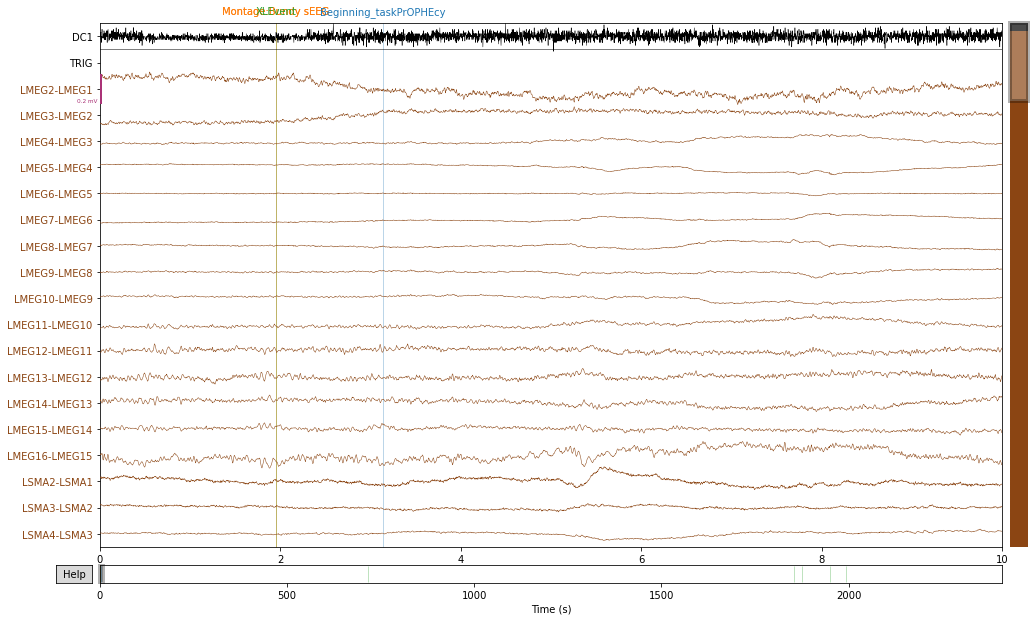

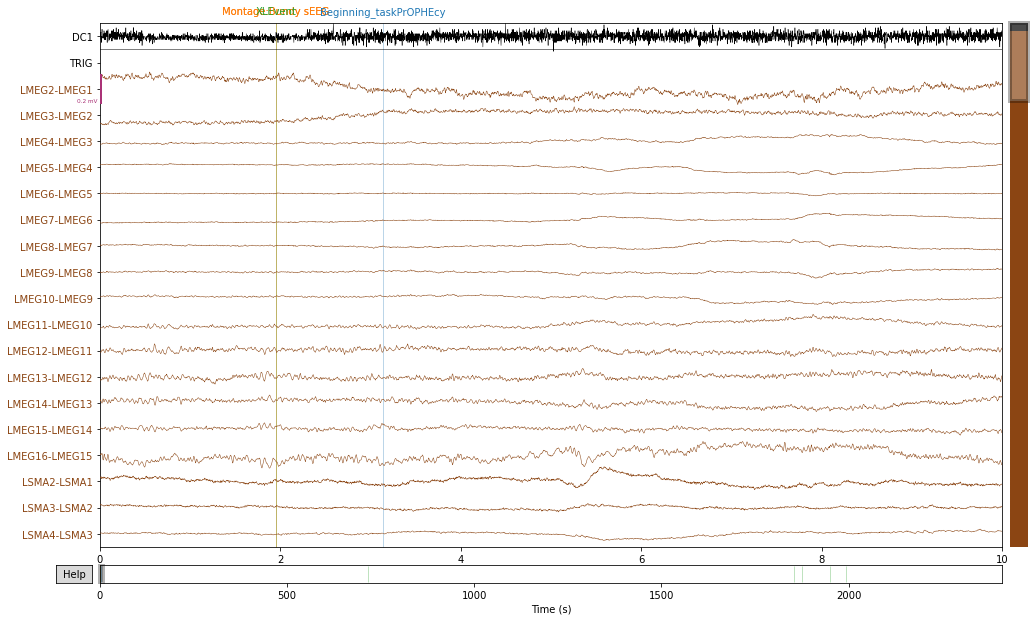

In [39]:
raw_bip_ref = bipolar_reference(raw, shank_list, trig_list)
raw_bip_ref.plot()

## 5.3 Spatial rereferencing

Spatial rereferencing is performed with the objective of identifying a particular type (i.e. frequency band/oscillation) of activity. This approach uses PCA to identify components that capture this activity in conjuction with a spatially-derived coefficient matrix to optimally rereference data to optimally capture the spatial aspects of the activity of interest.

In [17]:
montage = raw_annotate.get_montage()

In [19]:
print(montage)

None


In [16]:
mne.viz.plot_montage()

TypeError: plot_montage() missing 1 required positional argument: 'montage'

## Epoching

1. DC1 filtering
2. DC1 thresholding (for binary stim on/off)
3. rectify trig channel? (necessary?)
4. generate new trig channel for true stim onset
5. use new channel for epoching into trials (raw.info.events)

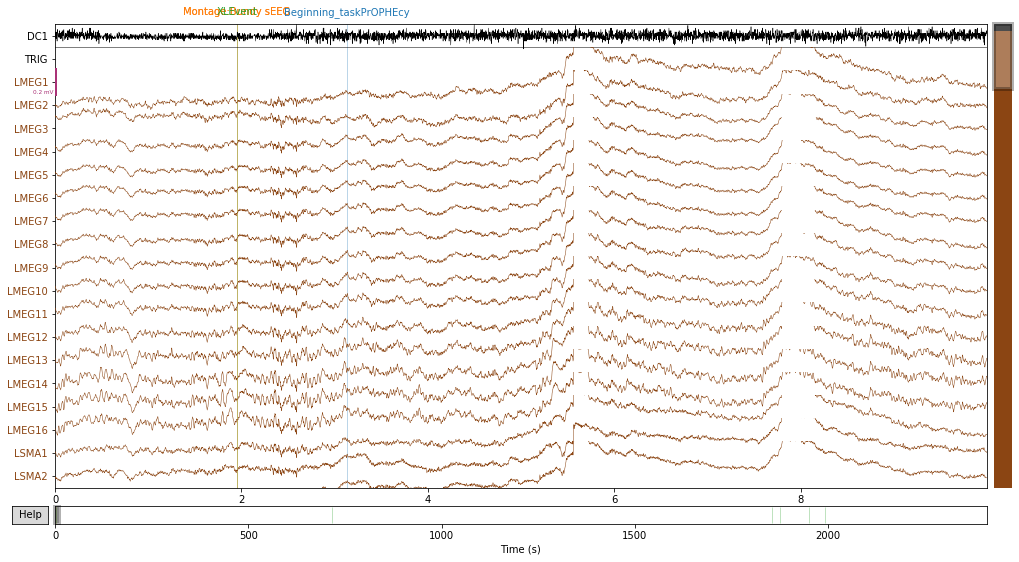

In [5]:
%matplotlib qt

raw.plot()

In [19]:
raw_copy = raw.copy()

In [6]:
# raw_copy.save('1002_annotated_raw.fif')

#raw_annot = mne.io.read_raw_fif('1002_annotated_raw.fif')
raw_annot = mne.io.read_raw_fif('/Users/sydneysmith/Projects/PrOPHEcy/Preprocessing/1002_events_raw.fif')

Opening raw data file /Users/sydneysmith/Projects/PrOPHEcy/Preprocessing/1002_events_raw.fif...
Isotrak not found
    Range : 0 ... 1234047 =      0.000 ...  2410.248 secs
Ready.


I saved a copy of the annotated file so we don't have to do the same next time. We can load it using this:

raw_copy = mne.io.read_raw_fif('.1002_annotated_raw.fif')

In [3]:
raw_annot.load_data()

Reading 0 ... 87301  =      0.000 ...   170.510 secs...


<Raw | 1002_annotated_raw.fif, 144 x 87302 (170.5 s), ~96.1 MB, data loaded>

In [22]:
dc1 = raw_annot.get_data(picks='DC1').flatten()
trig = raw_annot.get_data(picks='TRIG').flatten()

In [23]:
list(descriptions).count('begin_trial')

16

In [24]:
missing_onsets = []

for i, ann in enumerate(descriptions):
    if ann[0] == 'm':
        missing_onsets.append(onsets[i])

In [25]:
missing_onsets

[65.505653,
 65.95639,
 81.922249,
 82.887604,
 117.351013,
 129.325668,
 132.018845,
 154.336395,
 168.509537]

In [ ]:
# new trigger channel

# combine trig + new chan of onsets from annotations

In [26]:
norm_trig = trig + abs(trig[0])
norm_trig = abs(norm_trig)
norm_trig

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
trig_ind = np.where(norm_trig!=0)
new_trig = np.zeros_like(norm_trig)
for ind in trig_ind:
    new_trig[ind] = 1.
    
for onset in missing_onsets:
    ind = int(onset*raw_annot.info['sfreq'])
    new_trig[ind] = 2.

In [35]:
# add new_trig as a channel to MNE raw

info = mne.create_info(['STI'], raw.info['sfreq'], ['stim'])
new_trig = np.reshape(new_trig, [1,87302])
stim_raw = mne.io.RawArray(new_trig, info)
raw_annot.add_channels([stim_raw], force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=87302
    Range : 0 ... 87301 =      0.000 ...   170.510 secs
Ready.


<Raw | 1002_annotated_raw.fif, 145 x 87302 (170.5 s), ~96.7 MB, data loaded>

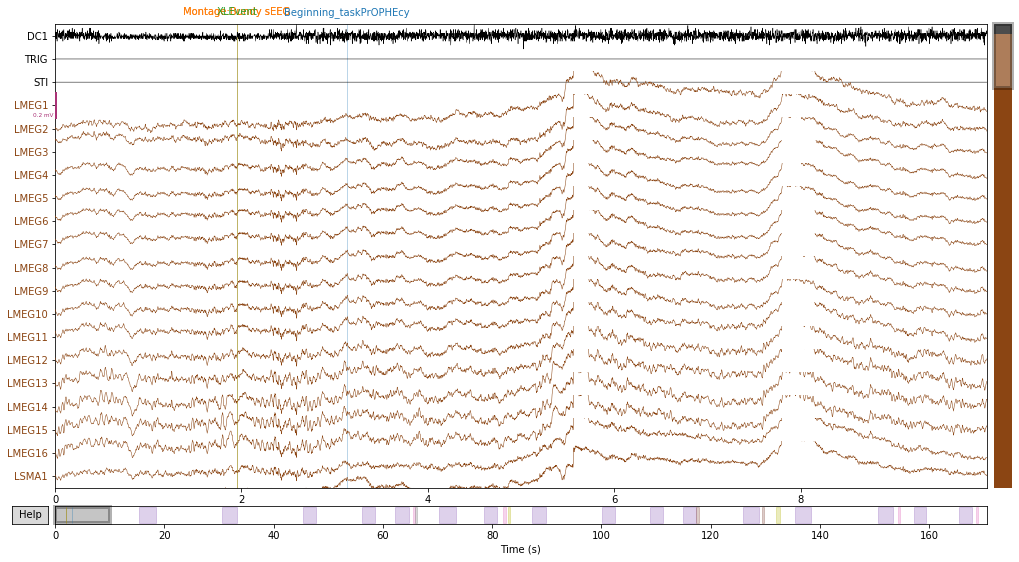

Channels marked as bad: none


In [37]:
%matplotlib qt
raw_annot.plot()

In [4]:
# get DC1 channel data
dc1 = raw.get_data(picks='DC1').flatten()

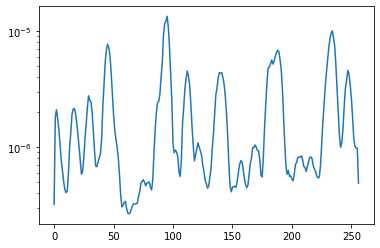

In [5]:
# compute and plot psd to pick narrowband filter range
freqs, psd = spectral.compute_spectrum_welch(dc1, fs=raw.info['sfreq'])

plt.plot(freqs, psd.flatten())
plt.yscale('log')

In [110]:
# filter data, get amplitude envelope
dc1_filt = filt.filter_signal(dc1, fs=raw.info['sfreq'], pass_type='bandpass', f_range=[45,50], remove_edges=False)
dc1_hilb = np.abs(sp.signal.hilbert(dc1_filt))

# smooth
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

smoothed_dc1 = moving_average(dc1_hilb, n=10)

/Users/sydneysmith/opt/anaconda3/lib/python3.7/site-packages/neurodsp/filt/checks.py:173: UserWarning: Transition bandwidth is  13.8  Hz. This is greater than the desiredpass/stop bandwidth of  5.0 Hz
  'pass/stop bandwidth of  {:.1f} Hz'.format(transition_bw, pass_bw))


In [49]:
trig = raw.get_data(picks='TRIG').flatten()
norm_trig = trig + abs(trig[0])
norm_trig = abs(norm_trig)

In [27]:
norm_trig.shape

(1234048,)

In [12]:
raw.info['sfreq']

512.0

In [9]:
%matplotlib qt

In [75]:
# plot
x = np.linspace(0,20,int(20*raw.info['sfreq']))

start = 167
stop = 187

#plt.plot(x, dc1[int(start*raw.info['sfreq']):int(stop*raw.info['sfreq'])])
plt.plot(x, trig[int(start*raw.info['sfreq']):int(stop*raw.info['sfreq'])])
plt.plot(x, dc1_filt[int(start*raw.info['sfreq']):int(stop*raw.info['sfreq'])])
plt.plot(x, dc1_hilb[int(start*raw.info['sfreq']):int(stop*raw.info['sfreq'])])
plt.plot(x, smoothed_dc1[int(start*raw.info['sfreq']):int(stop*raw.info['sfreq'])])
plt.plot(x, norm_trig[int(start*raw.info['sfreq']):int(stop*raw.info['sfreq'])])

In [53]:
trig_ind = sp.signal.find_peaks(norm_trig, height=0.00001)

In [54]:
trig_ind[0].shape

(914,)

In [121]:
dc_peaks = sp.signal.find_peaks(smoothed_dc1, height=0.0015, distance=int(220*512/1000))

In [122]:
dc_peaks[0].shape

(998,)

### data exploration

Effective window size : 4.000 (s)


<ipython-input-9-b92cd71cbcf7>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=raw.info['ch_names'][0:16], fmax=150 );


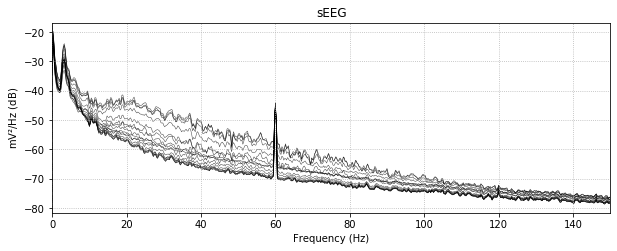

In [9]:
raw.plot_psd(picks=raw.info['ch_names'][0:16], fmax=150 );

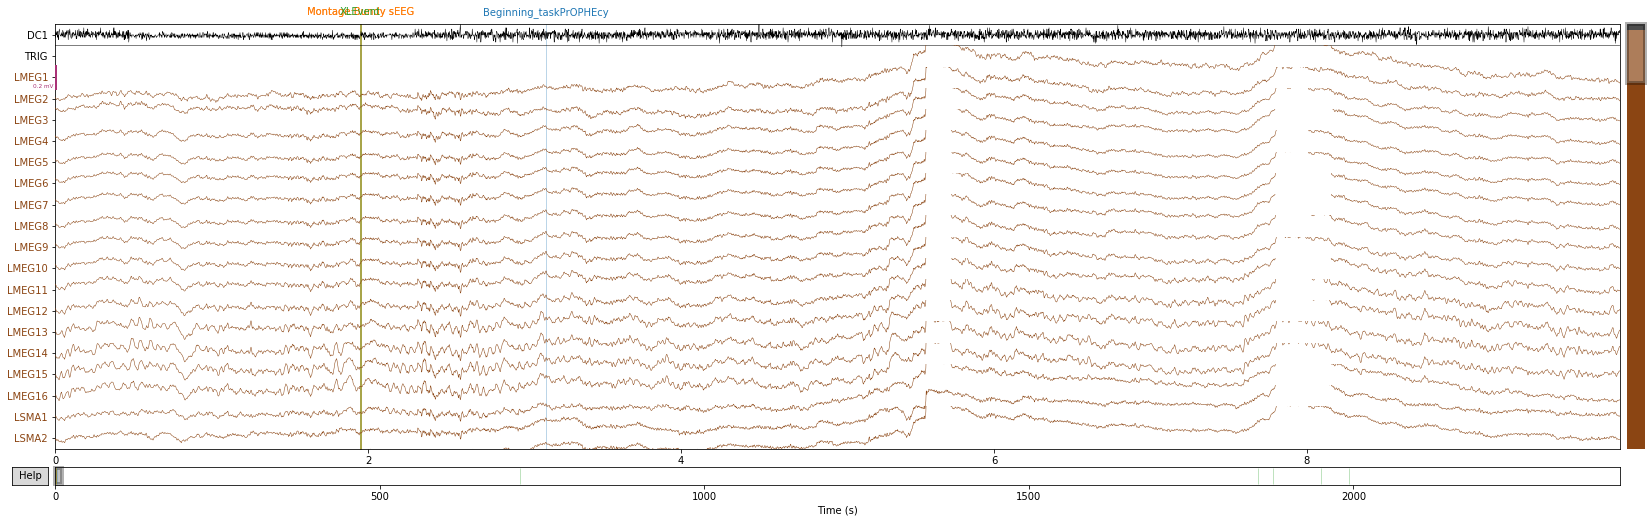

In [123]:
raw.plot()

In [26]:
mne.find_events(raw, stim_channel='TRIG', output='offset')

array([], shape=(0, 3), dtype=int32)

In [9]:
trig = raw.get_data(picks='TRIG')

In [21]:
norm_trig = trig + abs(trig[0])

In [22]:
norm_trig

array([[0., 0., 0., ..., 0., 0., 0.]])

# epoching
- event onset from trigger
- rectify with DC1 (or hilbert, unfiltered)

# artifact detection
- garbage trials manually (minimize false positives for noise rejection)
- if more than x channels have values 2std, FLAG (iterate) --> then manual

# rereferencing
- find clinical notes of reference electrode
- not common avg
- common avg per shank if necessary
- @bender -- spatial rereferencing in iEEG w/Natalie

# filtering
- medical equipment frequencies 
- look at power spectra after referencing

# data exploration
- plot, explore, spectra

# Meta-teaching
- save example trials for training primer


In [124]:
raw.plot(start=1800);

In [125]:
raw.info['bads']

[]

Channels marked as bad: ['LMEG1']


In [126]:
raw.info['bads']

['LMEG1']